In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pathlib import Path
import warnings
import psycopg2
import time
from sqlalchemy import create_engine
warnings.filterwarnings('ignore')
import sys
import pickle
from pprint import pprint
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
from scipy.stats import chi2_contingency 
sys.path.insert(0, os.path.realpath('..\..\src'))
from database.database_config import DB_NAME, DB_HOST, DB_USER, DB_PASSWORD

In [2]:
#testing connecting to database and getting back data
db = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}/{DB_NAME}")
conn = db.connect()

In [3]:
SQL = """
select
	match_id,
	mf.date_id,
	mf.venue_id,
	mf.referee_id,
	home_team_id as home_id,
	away_team_id as away_id,
	attendance,
    match_week,
	xg_home,
	xg_away,
	home_goal,
	away_goal,
	home_captain_name,
	away_captain_name,
	home_formation,
	away_formation,
	home_possession,
	away_possession,
	home_shots,
	home_shots_on_target,
	home_distance,
	home_freekicks,
	home_penalty_kicks,
	home_touches,
	home_touches_att_pen,
	home_touches_def_pen,
	home_touches_def_third,
	home_touches_mid_third,
	home_touches_att_third,
	home_touches_live,
	home_dribbles_success,
	home_dribbles_att,
	home_dribbles_mis,
	home_dribbles_dis,
	home_receiving_rec,
	home_receiving_prog,
	away_shots,
	away_shots_on_target,
	away_distance,
	away_freekicks,
	away_penalty_kicks,
	away_touches,
	away_touches_att_pen,
	away_touches_def_pen,
	away_touches_def_third,
	away_touches_mid_third,
	away_touches_att_third,
	away_touches_live,
	away_dribbles_success,
	away_dribbles_att,
	away_dribbles_mis,
	away_dribbles_dis,
	away_receiving_rec,
	away_receiving_prog,
	match_result,
	ht.team_name as home_team,
	aw.team_name as away_team,
	md."_date_",
	md."_time_" ,
	md."_day_",
	extract(MONTH from md."_date_") AS month,
	extract(DAY from md."_date_") AS day_of_month,
	extract(DOW from md."_date_") AS day_of_week,
	extract(YEAR from md."_date_") AS year,
	extract(HOUR from md."_time_") AS hour,
	extract(MINUTE from md."_time_") AS minute,
    extract(SECOND from md."_time_") AS second,
	mr.referee_name,
	mv.venue_name
from
	laliga_wh.match_facts mf
inner join laliga_wh.match_teams ht 
on
	ht.team_id = mf.home_team_id
inner join laliga_wh.match_teams aw 
on
	aw.team_id = mf.away_team_id
inner join laliga_wh.match_dates md 
on
	md.date_id = mf.date_id
inner join laliga_wh.match_referees mr 
on
	mr.referee_id = mf.referee_id
inner join laliga_wh.match_venues mv 
on
	mv.venue_id = mf.venue_id
"""

In [4]:
match_df = pd.read_sql(SQL, con=conn)
match_df.head()

,match_id,date_id,venue_id,referee_id,home_id,away_id,attendance,match_week,xg_home,xg_away,...,_day_,month,day_of_month,day_of_week,year,hour,minute,second,referee_name,venue_name
0,1,1,13,23,18,1,9231.0,1,1.3,1.1,...,Fri,8.0,18.0,5.0,2017.0,20.0,15.0,0.0,José Munuera,Estadio Municipal de Butarque
1,2,2,25,19,27,17,35971.0,1,1.4,0.2,...,Fri,8.0,18.0,5.0,2017.0,22.0,15.0,0.0,Jesús Gil,Estadio de Mestalla
2,3,3,22,7,7,25,16961.0,1,1.8,2.1,...,Sat,8.0,19.0,6.0,2017.0,18.0,15.0,0.0,Antonio Matéu Lahoz,Estadio de Balaídos
3,4,4,3,25,13,4,11511.0,1,2.2,0.7,...,Sat,8.0,19.0,6.0,2017.0,20.0,15.0,0.0,Juan Martínez,Estadi Municipal de Montilivi
4,5,5,18,4,26,11,30487.0,1,2.4,1.3,...,Sat,8.0,19.0,6.0,2017.0,22.0,15.0,0.0,Alejandro Hernández,Estadio Ramón Sánchez Pizjuán


# Preprocess

In [5]:
# Drop id columns
match_results = match_df.iloc[:,6:]

In [6]:
for i,v in match_results.dtypes.iteritems():
    print(i, v)

attendance float64
match_week int64
xg_home float64
xg_away float64
home_goal int64
away_goal int64
home_captain_name object
away_captain_name object
home_formation object
away_formation object
home_possession float64
away_possession float64
home_shots int64
home_shots_on_target int64
home_distance float64
home_freekicks int64
home_penalty_kicks int64
home_touches int64
home_touches_att_pen int64
home_touches_def_pen int64
home_touches_def_third int64
home_touches_mid_third int64
home_touches_att_third int64
home_touches_live int64
home_dribbles_success int64
home_dribbles_att int64
home_dribbles_mis int64
home_dribbles_dis int64
home_receiving_rec int64
home_receiving_prog int64
away_shots int64
away_shots_on_target int64
away_distance float64
away_freekicks int64
away_penalty_kicks int64
away_touches int64
away_touches_att_pen int64
away_touches_def_pen int64
away_touches_def_third int64
away_touches_mid_third int64
away_touches_att_third int64
away_touches_live int64
away_dribbles_s

In [7]:
# Fix data types for certain columns
match_results['attendance'] = match_results['attendance'].astype(pd.Int64Dtype())
match_results['_date_'] = pd.to_datetime(match_results['_date_'])
# int_columns = match_results.select_dtypes(include=['Int64', 'int64']).columns
# float_columns = match_results.select_dtypes(include=['float64']).columns
# match_results[int_columns] = match_results[int_columns].astype('int64')
# match_results[float_columns] = match_results[float_columns].astype('np.float32')
match_results['month'] = match_results['month'].astype('int64')
match_results['day_of_month'] = match_results['day_of_month'].astype('int64')
match_results['day_of_week'] = match_results['day_of_week'].astype('int64')
match_results['year'] = match_results['year'].astype('int64')
match_results['hour'] = match_results['hour'].astype('int64')
match_results['minute'] = match_results['minute'].astype('int64')
match_results['second'] = match_results['second'].astype('int64')
match_results.drop(['_day_', '_time_'], axis = 1, inplace = True) # Not needed as we created numerical columns for the date components

In [8]:
match_results['home_formation'].value_counts()

4-4-2         695
4-2-3-1       391
4-3-3         347
4-1-4-1       124
3-4-3          84
3-5-2          67
5-3-2          64
4-1-3-2        45
4-4-1-1        44
3-1-4-2        38
4-1-2-1-2◆     32
5-4-1          26
3-4-1-2        16
4-3-1-2        12
4-5-1          11
3-5-1-1         5
4-2-2-2         5
4-3-2-1         2
3-4-3◆          1
4-2-4-0         1
Name: home_formation, dtype: int64

In [9]:
# Clean up formations
match_results['home_formation'] = match_results['home_formation'].replace({'4-4-2◆': '4-4-2', '4-3-1-2◆':'4-3-1-2', '4-3-3◆':'4-3-3', '4-1-3-2◆':'4-1-3-2',
                                         '4-2-3-1◆':'4-2-3-1', '3-4-3◆':'3-4-3', '4-1-2-1-2◆': '4-1-2-1-2'})
match_results['away_formation'] = match_results['away_formation'].replace({'4-4-2◆': '4-4-2', '4-3-1-2◆':'4-3-1-2', '4-3-3◆':'4-3-3', '4-1-3-2◆':'4-1-3-2',
                                         '4-2-3-1◆':'4-2-3-1', '3-4-3◆':'3-4-3', '4-3-2-1◆':'4-3-2-1', '4-1-2-1-2◆': '4-1-2-1-2'})

# Time Frame of Our Data

In [10]:
print('Start Date: ', min(match_results._date_.dt.date))
print('End Date: ', max(match_results._date_.dt.date))

Start Date:  2017-08-18
End Date:  2022-10-24


We have data from August 2017 to October 2022. This encompasses the 2017-2018 to the 2021-2022 season. We want to do our analysis up until the end of the 2021-22 season

In [11]:
start_date = '2017-08-01'
end_date = '2022-05-30'
mask = (match_results['_date_'] > start_date) & (match_results['_date_'] <= end_date)
match_results = match_results.loc[mask]

In [12]:
# Count number of missing values
for i, v in match_results.isna().sum().iteritems():
    print(i + '\t' + str(v))

attendance	488
match_week	0
xg_home	0
xg_away	0
home_goal	0
away_goal	0
home_captain_name	0
away_captain_name	0
home_formation	0
away_formation	0
home_possession	0
away_possession	0
home_shots	0
home_shots_on_target	0
home_distance	0
home_freekicks	0
home_penalty_kicks	0
home_touches	0
home_touches_att_pen	0
home_touches_def_pen	0
home_touches_def_third	0
home_touches_mid_third	0
home_touches_att_third	0
home_touches_live	0
home_dribbles_success	0
home_dribbles_att	0
home_dribbles_mis	0
home_dribbles_dis	0
home_receiving_rec	0
home_receiving_prog	0
away_shots	0
away_shots_on_target	0
away_distance	2
away_freekicks	0
away_penalty_kicks	0
away_touches	0
away_touches_att_pen	0
away_touches_def_pen	0
away_touches_def_third	0
away_touches_mid_third	0
away_touches_att_third	0
away_touches_live	0
away_dribbles_success	0
away_dribbles_att	0
away_dribbles_mis	0
away_dribbles_dis	0
away_receiving_rec	0
away_receiving_prog	0
match_result	0
home_team	0
away_team	0
_date_	0
month	0
day_of_month	0
d

In [13]:
# Drop attendance. We have MCAR data here and not recommended to keep it
# Drop _date_. We already split this into numerical components
# Fill other columns with 1 or 2 missing values with median
match_results.drop(['attendance', '_date_', 'match_week'], axis = 1, inplace = True)
match_results[ 'away_distance'] = match_results[ 'away_distance'].fillna(match_results['away_distance'].median())
int_columns = match_results.select_dtypes(include=['Int64', 'int64']).columns
match_results[int_columns] = match_results[int_columns].astype('int64')

In [14]:
# Count number of missing values
for i, v in match_results.isna().sum().iteritems():
    print(i + '\t' + str(v))

xg_home	0
xg_away	0
home_goal	0
away_goal	0
home_captain_name	0
away_captain_name	0
home_formation	0
away_formation	0
home_possession	0
away_possession	0
home_shots	0
home_shots_on_target	0
home_distance	0
home_freekicks	0
home_penalty_kicks	0
home_touches	0
home_touches_att_pen	0
home_touches_def_pen	0
home_touches_def_third	0
home_touches_mid_third	0
home_touches_att_third	0
home_touches_live	0
home_dribbles_success	0
home_dribbles_att	0
home_dribbles_mis	0
home_dribbles_dis	0
home_receiving_rec	0
home_receiving_prog	0
away_shots	0
away_shots_on_target	0
away_distance	0
away_freekicks	0
away_penalty_kicks	0
away_touches	0
away_touches_att_pen	0
away_touches_def_pen	0
away_touches_def_third	0
away_touches_mid_third	0
away_touches_att_third	0
away_touches_live	0
away_dribbles_success	0
away_dribbles_att	0
away_dribbles_mis	0
away_dribbles_dis	0
away_receiving_rec	0
away_receiving_prog	0
match_result	0
home_team	0
away_team	0
month	0
day_of_month	0
day_of_week	0
year	0
hour	0
minute	0
s

In [15]:
match_results.head()

,xg_home,xg_away,home_goal,away_goal,home_captain_name,away_captain_name,home_formation,away_formation,home_possession,away_possession,...,away_team,month,day_of_month,day_of_week,year,hour,minute,second,referee_name,venue_name
0,1.3,1.1,1,0,Martín Mantovani,Manu García,4-2-3-1,4-4-2,53.0,47.0,...,Alavés,8,18,5,2017,20,15,0,José Munuera,Estadio Municipal de Butarque
1,1.4,0.2,1,0,Daniel Parejo,Jonathan Viera,4-4-2,4-1-4-1,47.0,53.0,...,Las Palmas,8,18,5,2017,22,15,0,Jesús Gil,Estadio de Mestalla
2,1.8,2.1,2,3,Hugo Mallo,Xabi Prieto,4-3-3,4-3-3,53.0,47.0,...,Real Sociedad,8,19,6,2017,18,15,0,Antonio Matéu Lahoz,Estadio de Balaídos
3,2.2,0.7,2,2,Álex Granell,Gabi,3-4-3,4-4-2,52.0,48.0,...,Atlético Madrid,8,19,6,2017,20,15,0,Juan Martínez,Estadi Municipal de Montilivi
4,2.4,1.3,1,1,Jesús Navas,Gerard Moreno,4-1-4-1,4-4-2,62.0,38.0,...,Espanyol,8,19,6,2017,22,15,0,Alejandro Hernández,Estadio Ramón Sánchez Pizjuán


In [16]:
# One hot encode
match_results_encode = pd.get_dummies(match_results, columns = ['home_captain_name', 'away_captain_name', 'home_formation', 'away_formation',
                                                                'home_team', 'away_team', 'referee_name', 'venue_name'])

In [17]:
match_results_encode.head()

,xg_home,xg_away,home_goal,away_goal,home_possession,away_possession,home_shots,home_shots_on_target,home_distance,home_freekicks,...,venue_name_Estadio Wanda Metropolitano,venue_name_Estadio de Balaídos,venue_name_Estadio de Gran Canaria,venue_name_Estadio de Mendizorroza,venue_name_Estadio de Mestalla,venue_name_Estadio de la Cerámica,venue_name_Estadio del Rayo Vallecano,venue_name_Iberostar Estadi,venue_name_RCDE Stadium,venue_name_San Mamés
0,1.3,1.1,1,0,53.0,47.0,14,3,22.0,2,...,0,0,0,0,0,0,0,0,0,0
1,1.4,0.2,1,0,47.0,53.0,22,6,17.0,2,...,0,0,0,0,1,0,0,0,0,0
2,1.8,2.1,2,3,53.0,47.0,16,5,17.4,1,...,0,1,0,0,0,0,0,0,0,0
3,2.2,0.7,2,2,52.0,48.0,13,6,18.2,1,...,0,0,0,0,0,0,0,0,0,0
4,2.4,1.3,1,1,62.0,38.0,9,4,11.5,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
for i,v in match_results_encode.dtypes.iteritems():
    print(i, v)

xg_home float64
xg_away float64
home_goal int64
away_goal int64
home_possession float64
away_possession float64
home_shots int64
home_shots_on_target int64
home_distance float64
home_freekicks int64
home_penalty_kicks int64
home_touches int64
home_touches_att_pen int64
home_touches_def_pen int64
home_touches_def_third int64
home_touches_mid_third int64
home_touches_att_third int64
home_touches_live int64
home_dribbles_success int64
home_dribbles_att int64
home_dribbles_mis int64
home_dribbles_dis int64
home_receiving_rec int64
home_receiving_prog int64
away_shots int64
away_shots_on_target int64
away_distance float64
away_freekicks int64
away_penalty_kicks int64
away_touches int64
away_touches_att_pen int64
away_touches_def_pen int64
away_touches_def_third int64
away_touches_mid_third int64
away_touches_att_third int64
away_touches_live int64
away_dribbles_success int64
away_dribbles_att int64
away_dribbles_mis int64
away_dribbles_dis int64
away_receiving_rec int64
away_receiving_prog 

# Data Exploration

[Text(0, 0, '844'), Text(0, 0, '535'), Text(0, 0, '521')]

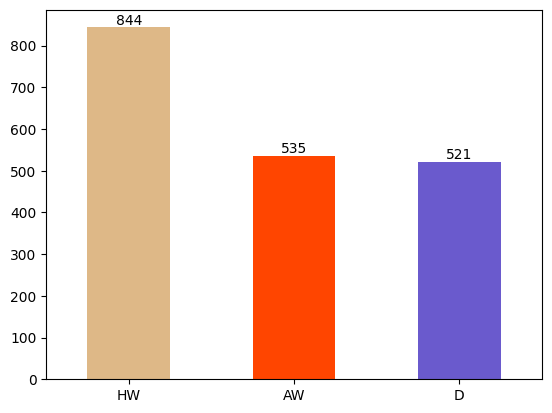

In [19]:
ax = match_results_encode['match_result'].value_counts().plot(kind = 'bar', color = ['burlywood', 'orangered', 'slateblue'], rot =0)
ax.plot()
ax.bar_label(ax.containers[0])

In [20]:
match_results_encode.groupby('match_result')['match_result'].count()

match_result
AW    535
D     521
HW    844
Name: match_result, dtype: int64

In [21]:
# get all records with El Clasico
clasico_matches = match_results_encode[((match_results_encode['home_team_Barcelona'] == 1) & (match_results_encode['away_team_Real Madrid'] == 1)) |
                                       ((match_results_encode['home_team_Real Madrid'] == 1) & (match_results_encode['away_team_Barcelona'] == 1))]

In [22]:
clasico_matches

,xg_home,xg_away,home_goal,away_goal,home_possession,away_possession,home_shots,home_shots_on_target,home_distance,home_freekicks,...,venue_name_Estadio Wanda Metropolitano,venue_name_Estadio de Balaídos,venue_name_Estadio de Gran Canaria,venue_name_Estadio de Mendizorroza,venue_name_Estadio de Mestalla,venue_name_Estadio de la Cerámica,venue_name_Estadio del Rayo Vallecano,venue_name_Iberostar Estadi,venue_name_RCDE Stadium,venue_name_San Mamés
166,1.0,2.6,0,3,45.0,55.0,14,5,15.2,0,...,0,0,0,0,0,0,0,0,0,0
356,1.4,2.0,2,2,50.0,50.0,11,4,15.1,1,...,0,0,0,0,0,0,0,0,0,0
477,3.0,2.1,5,1,53.0,47.0,12,7,17.6,0,...,0,0,0,0,0,0,0,0,0,0
634,0.9,1.1,0,1,49.0,51.0,17,3,18.8,1,...,0,0,0,0,0,0,0,0,0,0
929,0.9,0.8,0,0,52.0,48.0,9,1,17.5,1,...,0,0,0,0,0,0,0,0,0,0
1018,1.1,1.5,2,0,44.0,56.0,13,4,17.7,1,...,0,0,0,0,0,0,0,0,0,0
1194,1.8,3.0,1,3,53.0,47.0,10,4,17.3,1,...,0,0,0,0,0,0,0,0,0,0
1434,1.5,1.3,2,1,31.0,69.0,14,3,18.0,2,...,0,0,0,0,0,0,0,0,0,0
1612,1.8,1.7,1,2,51.0,49.0,12,2,15.2,0,...,0,0,0,0,0,0,0,0,0,0
1808,1.1,2.7,0,4,40.0,60.0,14,4,20.1,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
clasico_matches['home_team_Barcelona'].value_counts()

0    5
1    5
Name: home_team_Barcelona, dtype: int64

In [24]:
def create_clasico_result(row):
    if row.match_result == 'HW' and row['home_team_Barcelona'] == 1:
        return 'Barcelona Win'
    elif row.match_result == 'AW' and row['away_team_Barcelona'] == 1:
        return 'Barcelona Win'
    elif row.match_result == 'HW' and row['home_team_Real Madrid'] == 1:
        return 'Real Madrid Win'
    elif row.match_result == 'AW' and row['away_team_Real Madrid'] == 1:
        return 'Real Madrid Win'
    else:
        return 'Draw'
    

In [25]:
clasico_matches['clasico_result'] = clasico_matches.apply(create_clasico_result, axis =1)

[Text(0, 0, '4'), Text(0, 0, '4'), Text(0, 0, '2')]

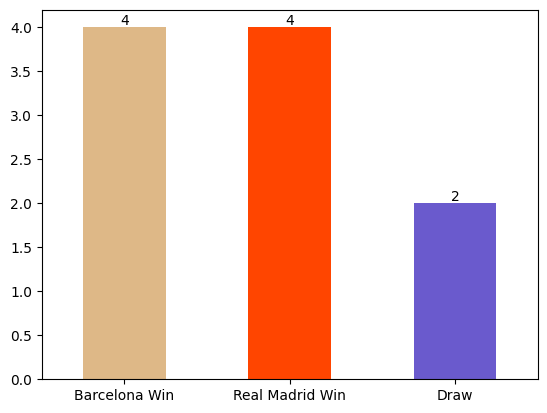

In [26]:
ax = clasico_matches['clasico_result'].value_counts().plot(kind = 'bar', color = ['burlywood', 'orangered', 'slateblue'], rot = 0)
ax.plot()
ax.bar_label(ax.containers[0])

In [27]:
#Select all our numerical columns
numerical_columns = match_results_encode.select_dtypes(include=['Int64', 'int64', 'float64', 'int32'])

In [28]:
numerical_columns

,xg_home,xg_away,home_goal,away_goal,home_possession,away_possession,home_shots,home_shots_on_target,home_distance,home_freekicks,...,away_dribbles_dis,away_receiving_rec,away_receiving_prog,month,day_of_month,day_of_week,year,hour,minute,second
0,1.3,1.1,1,0,53.0,47.0,14,3,22.0,2,...,13,250,13,8,18,5,2017,20,15,0
1,1.4,0.2,1,0,47.0,53.0,22,6,17.0,2,...,7,435,17,8,18,5,2017,22,15,0
2,1.8,2.1,2,3,53.0,47.0,16,5,17.4,1,...,9,340,19,8,19,6,2017,18,15,0
3,2.2,0.7,2,2,52.0,48.0,13,6,18.2,1,...,6,345,35,8,19,6,2017,20,15,0
4,2.4,1.3,1,1,62.0,38.0,9,4,11.5,0,...,12,289,18,8,19,6,2017,22,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,2.0,0.5,0,0,40.0,60.0,14,5,18.7,1,...,8,454,27,5,22,0,2022,20,0,0
1896,0.8,1.4,0,2,62.0,38.0,11,1,16.0,0,...,7,199,18,5,22,0,2022,20,0,0
1897,0.9,0.7,0,2,69.0,31.0,14,3,20.3,0,...,10,254,13,5,22,0,2022,22,0,0
1898,2.5,0.8,1,2,62.0,38.0,12,3,16.0,2,...,13,264,12,5,22,0,2022,22,0,0


In [29]:
# for i in numerical_columns:
#     print(i)

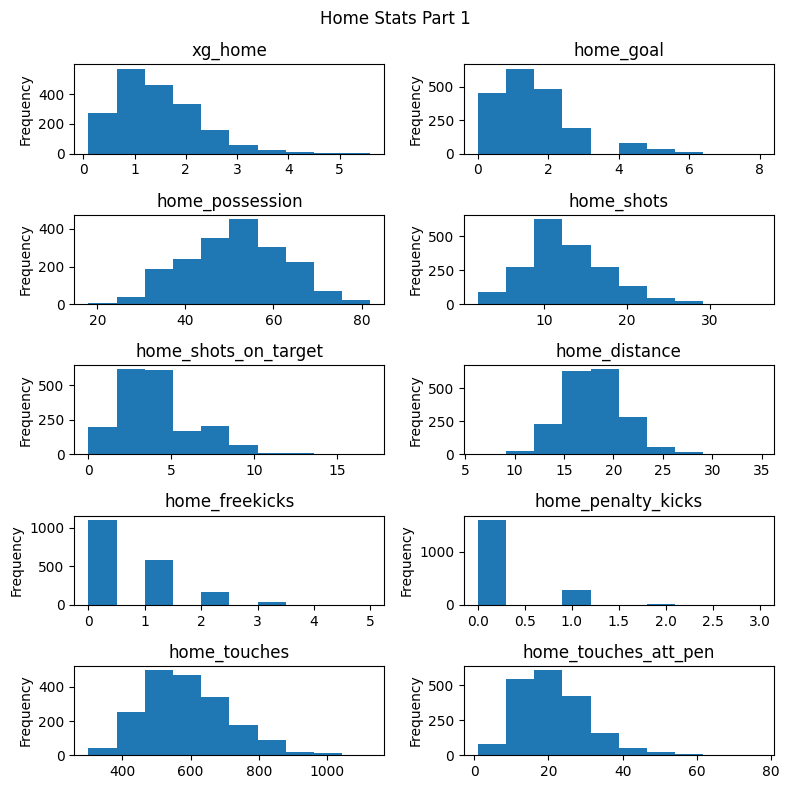

In [30]:
fig1, ax1 = plt.subplots(nrows=5, ncols= 2,figsize=(8, 8))
numerical_columns['xg_home'].plot.hist(ax =ax1[0,0], title = 'xg_home')
numerical_columns['home_goal'].plot.hist(ax =ax1[0,1], title = 'home_goal')
numerical_columns['home_possession'].plot.hist(ax =ax1[1,0], title = 'home_possession')
numerical_columns['home_shots'].plot.hist(ax =ax1[1,1], title = 'home_shots')
numerical_columns['home_shots_on_target'].plot.hist(ax =ax1[2,0], title = 'home_shots_on_target')
numerical_columns['home_distance'].plot.hist(ax =ax1[2,1], title = 'home_distance')
numerical_columns['home_freekicks'].plot.hist(ax =ax1[3,0], title = 'home_freekicks')
numerical_columns['home_penalty_kicks'].plot.hist(ax =ax1[3,1], title = 'home_penalty_kicks')
numerical_columns['home_touches'].plot.hist(ax =ax1[4,0], title = 'home_touches')
numerical_columns['home_touches_att_pen'].plot.hist(ax =ax1[4,1], title = 'home_touches_att_pen')

plt.suptitle('Home Stats Part 1')
plt.tight_layout()
plt.show()

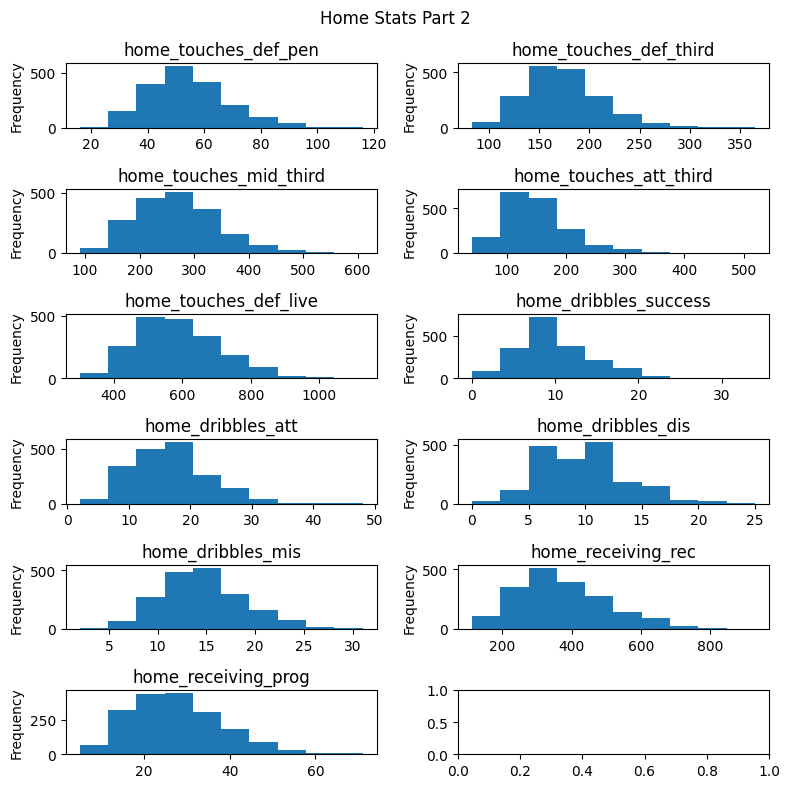

In [31]:
fig2, ax2 = plt.subplots(nrows=6, ncols= 2,figsize=(8, 8))
numerical_columns['home_touches_def_pen'].plot.hist(ax =ax2[0,0], title = 'home_touches_def_pen')
numerical_columns['home_touches_def_third'].plot.hist(ax =ax2[0,1], title = 'home_touches_def_third')
numerical_columns['home_touches_mid_third'].plot.hist(ax =ax2[1,0], title = 'home_touches_mid_third')
numerical_columns['home_touches_att_third'].plot.hist(ax =ax2[1,1], title = 'home_touches_att_third')
numerical_columns['home_touches_live'].plot.hist(ax =ax2[2,0], title = 'home_touches_def_live')
numerical_columns['home_dribbles_success'].plot.hist(ax =ax2[2,1], title = 'home_dribbles_success')
numerical_columns['home_dribbles_att'].plot.hist(ax =ax2[3,0], title = 'home_dribbles_att')
numerical_columns['home_dribbles_dis'].plot.hist(ax =ax2[3,1], title = 'home_dribbles_dis')
numerical_columns['home_dribbles_mis'].plot.hist(ax =ax2[4,0], title = 'home_dribbles_mis')
numerical_columns['home_receiving_rec'].plot.hist(ax =ax2[4,1], title = 'home_receiving_rec')
numerical_columns['home_receiving_prog'].plot.hist(ax =ax2[5,0], title = 'home_receiving_prog')

plt.suptitle('Home Stats Part 2')
plt.tight_layout()
plt.show()

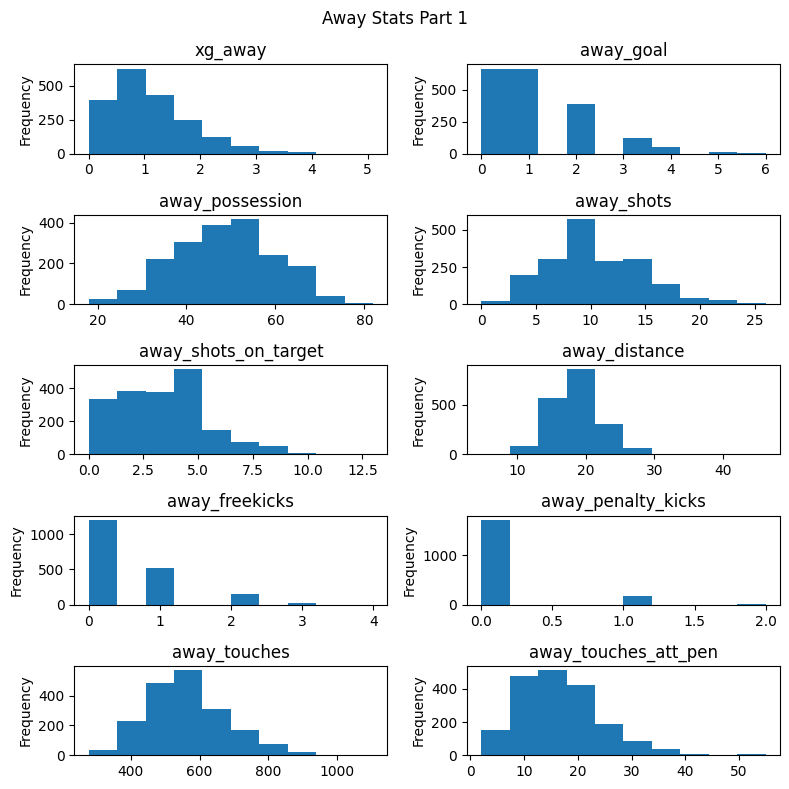

In [32]:
fig1, ax1 = plt.subplots(nrows=5, ncols= 2,figsize=(8, 8))
numerical_columns['xg_away'].plot.hist(ax =ax1[0,0], title = 'xg_away')
numerical_columns['away_goal'].plot.hist(ax =ax1[0,1], title = 'away_goal')
numerical_columns['away_possession'].plot.hist(ax =ax1[1,0], title = 'away_possession')
numerical_columns['away_shots'].plot.hist(ax =ax1[1,1], title = 'away_shots')
numerical_columns['away_shots_on_target'].plot.hist(ax =ax1[2,0], title = 'away_shots_on_target')
numerical_columns['away_distance'].plot.hist(ax =ax1[2,1], title = 'away_distance')
numerical_columns['away_freekicks'].plot.hist(ax =ax1[3,0], title = 'away_freekicks')
numerical_columns['away_penalty_kicks'].plot.hist(ax =ax1[3,1], title = 'away_penalty_kicks')
numerical_columns['away_touches'].plot.hist(ax =ax1[4,0], title = 'away_touches')
numerical_columns['away_touches_att_pen'].plot.hist(ax =ax1[4,1], title = 'away_touches_att_pen')

plt.suptitle('Away Stats Part 1')
plt.tight_layout()
plt.show()

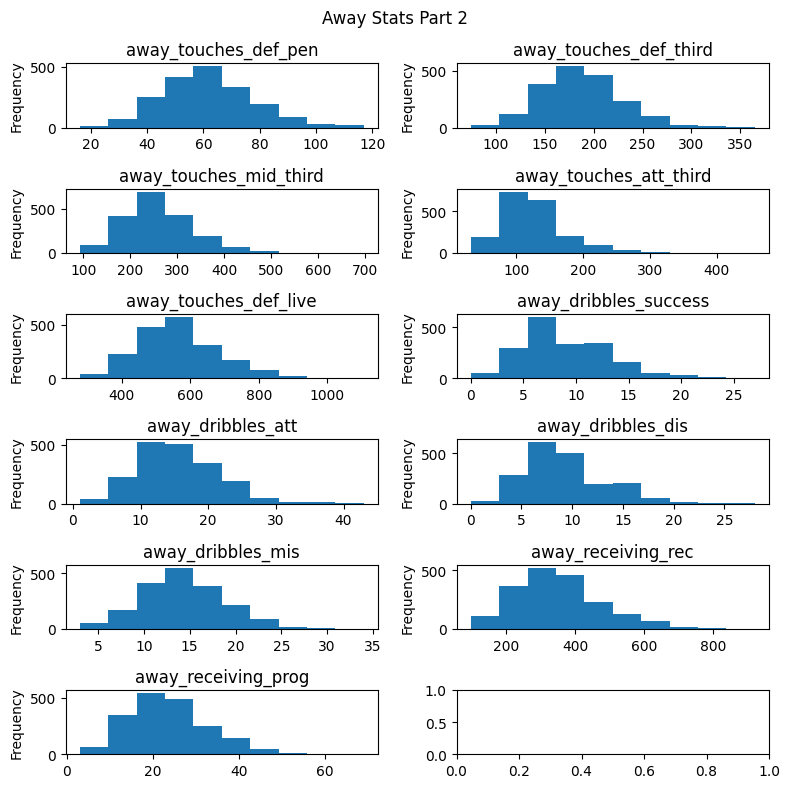

In [33]:
fig2, ax2 = plt.subplots(nrows=6, ncols= 2,figsize=(8, 8))
numerical_columns['away_touches_def_pen'].plot.hist(ax =ax2[0,0], title = 'away_touches_def_pen')
numerical_columns['away_touches_def_third'].plot.hist(ax =ax2[0,1], title = 'away_touches_def_third')
numerical_columns['away_touches_mid_third'].plot.hist(ax =ax2[1,0], title = 'away_touches_mid_third')
numerical_columns['away_touches_att_third'].plot.hist(ax =ax2[1,1], title = 'away_touches_att_third')
numerical_columns['away_touches_live'].plot.hist(ax =ax2[2,0], title = 'away_touches_def_live')
numerical_columns['away_dribbles_success'].plot.hist(ax =ax2[2,1], title = 'away_dribbles_success')
numerical_columns['away_dribbles_att'].plot.hist(ax =ax2[3,0], title = 'away_dribbles_att')
numerical_columns['away_dribbles_dis'].plot.hist(ax =ax2[3,1], title = 'away_dribbles_dis')
numerical_columns['away_dribbles_mis'].plot.hist(ax =ax2[4,0], title = 'away_dribbles_mis')
numerical_columns['away_receiving_rec'].plot.hist(ax =ax2[4,1], title = 'away_receiving_rec')
numerical_columns['away_receiving_prog'].plot.hist(ax =ax2[5,0], title = 'away_receiving_prog')

plt.suptitle('Away Stats Part 2')
plt.tight_layout()
plt.show()

# Chi-Square Analysis - Check correlation amongst categorical features

In [34]:
pd.set_option('display.max_columns', None)
match_results_encode.head()

,xg_home,xg_away,home_goal,away_goal,home_possession,away_possession,home_shots,home_shots_on_target,home_distance,home_freekicks,home_penalty_kicks,home_touches,home_touches_att_pen,home_touches_def_pen,home_touches_def_third,home_touches_mid_third,home_touches_att_third,home_touches_live,home_dribbles_success,home_dribbles_att,home_dribbles_mis,home_dribbles_dis,home_receiving_rec,home_receiving_prog,away_shots,away_shots_on_target,away_distance,away_freekicks,away_penalty_kicks,away_touches,away_touches_att_pen,away_touches_def_pen,away_touches_def_third,away_touches_mid_third,away_touches_att_third,away_touches_live,away_dribbles_success,away_dribbles_att,away_dribbles_mis,away_dribbles_dis,away_receiving_rec,away_receiving_prog,match_result,month,day_of_month,day_of_week,year,hour,minute,second,home_captain_name_Aday,home_captain_name_Adri Embarba,home_captain_name_Adrián López,home_captain_name_Aitor Fernández,home_captain_name_Alberto Cifuentes,home_captain_name_Alberto García,home_captain_name_Alexander,home_captain_name_Alexis,home_captain_name_Alfonso Espino,home_captain_name_Ander Capa,home_captain_name_Ander Iturraspe,home_captain_name_Andrés Guardado,home_captain_name_Andrés Iniesta,home_captain_name_Antoine Griezmann,home_captain_name_Antonio Adán,home_captain_name_Antonio Raillo,home_captain_name_Aritz Elustondo,home_captain_name_Asier Illarramendi,home_captain_name_Asier Riesgo,home_captain_name_Aïssa Mandi,home_captain_name_Borja Fernández,home_captain_name_Bruno González,home_captain_name_Bruno Soriano,home_captain_name_Carlos Soler,home_captain_name_Celso Borges,home_captain_name_Coke,home_captain_name_Cristhian Stuani,home_captain_name_Cristiano Ronaldo,home_captain_name_Damián Suárez,home_captain_name_Dani García,home_captain_name_Dani Giménez,home_captain_name_Daniel Carriço,home_captain_name_Daniel Parejo,home_captain_name_David García,home_captain_name_David López,home_captain_name_David Timor,home_captain_name_David Zurutuza,home_captain_name_Diego Godín,home_captain_name_Diego López,home_captain_name_Djené,home_captain_name_Dídac Vilà,home_captain_name_Esteban Granero,home_captain_name_Fernando,home_captain_name_Fernando Pacheco,home_captain_name_Fernando Torres,home_captain_name_Fidel,home_captain_name_Gabi,home_captain_name_Gabriel,home_captain_name_Gabriel Paulista,home_captain_name_Geoffrey Kondogbia,home_captain_name_Gerard Moreno,home_captain_name_Gerard Piqué,home_captain_name_Germán Sánchez,home_captain_name_Gonzalo Escalante,home_captain_name_Gonzalo Melero,home_captain_name_Gonzalo Verdú,home_captain_name_Gustavo Cabral,home_captain_name_Hugo Mallo,home_captain_name_Iago Aspas,home_captain_name_Igor Zubeldia,home_captain_name_Iker Muniain,home_captain_name_Ivan Rakitić,home_captain_name_Iván Marcone,home_captain_name_Iván Ramis,home_captain_name_Jaime Mata,home_captain_name_Jan Oblak,home_captain_name_Jaume Costa,home_captain_name_Jaume Doménech,home_captain_name_Javi García,home_captain_name_Javi López,home_captain_name_Javi Moyano,home_captain_name_Jesús Navas,home_captain_name_Joan Jordán,home_captain_name_Joaquín,home_captain_name_Jon Ander Garrido,home_captain_name_Jon Ander Serantes,home_captain_name_Jonathan Viera,home_captain_name_Jordi Alba,home_captain_name_Jordi Amat,home_captain_name_Jordi Masip,home_captain_name_Jorge Molina,home_captain_name_Jorge Pulido,home_captain_name_Joseba Zaldúa,home_captain_name_José Luis Gayà,home_captain_name_José Luis Morales,home_captain_name_José Mari,home_captain_name_Juanfran,home_captain_name_Karim Benzema,home_captain_name_Kike,home_captain_name_Koke,home_captain_name_Leandro Cabrera,home_captain_name_Lionel Messi,home_captain_name_Manolo Reina,home_captain_name_Manu García,home_captain_name_Manu Trigueros,home_captain_name_Manuel Iturra,home_captain_name_Marc-André ter Stegen,home_captain_name_Marcelo,home_captain_name_Marcos Mauro López Gutiérrez,home_captain_name_Mario Gaspar,home_captain_name_Mario Suárez,home_captain_name_Markel Susaeta,ho

In [35]:
cols=match_results_encode.drop(columns='match_result').columns

In [36]:
category_cols = list(set(cols) - set(numerical_columns))
count1=0
for i in category_cols:
    count1+=1
print(count1)    

496


In [37]:
count = 0
important_categories = []
for i in category_cols:
    chisqt = pd.crosstab(match_results_encode[i], match_results_encode['match_result'], margins = True)
    value = np.array([chisqt.iloc[0].values,
                  chisqt.iloc[1].values])
    stat, p, dof = chi2_contingency(value)[0:3]
    if p < 0.05:
        print(i + "\t"  + "\t" + str(p))
        important_categories.append(i)
        count+=1
print("Count of columns = " + str(count))    
    

venue_name_Camp Nou		1.07773960907413e-07
away_captain_name_Antonio Raillo		0.0322073292445226
home_team_Real Madrid		9.537521703010725e-06
away_captain_name_Koke		0.0030197478559186816
home_captain_name_Lionel Messi		8.655974457668748e-05
home_captain_name_Daniel Parejo		0.02815281502504988
venue_name_Estadio de Gran Canaria		0.001500360785905292
home_team_Sevilla		0.002772272253998243
home_team_Las Palmas		0.001500360785905292
away_captain_name_Gabi		0.02978111682412344
home_captain_name_Kike		0.011137151164567465
away_captain_name_Lionel Messi		8.381019523179344e-08
home_team_Cádiz		0.0335466755236691
home_captain_name_Diego Godín		0.017635274985600618
home_formation_4-3-3		1.6874216245689086e-06
away_team_Barcelona		1.2462016665514197e-10
away_captain_name_Víctor Laguardia		0.03237178071376302
away_captain_name_Sergio Ramos		0.0007317823079789799
venue_name_Estadio de Mestalla		0.031137733543252676
away_team_Real Madrid		8.26554022615819e-10
home_formation_4-5-1		0.0025684418392215

In [38]:
print(important_categories)

['venue_name_Camp Nou', 'away_captain_name_Antonio Raillo', 'home_team_Real Madrid', 'away_captain_name_Koke', 'home_captain_name_Lionel Messi', 'home_captain_name_Daniel Parejo', 'venue_name_Estadio de Gran Canaria', 'home_team_Sevilla', 'home_team_Las Palmas', 'away_captain_name_Gabi', 'home_captain_name_Kike', 'away_captain_name_Lionel Messi', 'home_team_Cádiz', 'home_captain_name_Diego Godín', 'home_formation_4-3-3', 'away_team_Barcelona', 'away_captain_name_Víctor Laguardia', 'away_captain_name_Sergio Ramos', 'venue_name_Estadio de Mestalla', 'away_team_Real Madrid', 'home_formation_4-5-1', 'home_captain_name_Markel Susaeta', 'away_captain_name_Bruno González', 'home_captain_name_Karim Benzema', 'home_formation_4-2-3-1', 'away_team_Rayo Vallecano', 'away_captain_name_Sergio Busquets', 'venue_name_Estadio Nuevo Mirandilla', 'away_captain_name_David López', 'home_team_Atlético Madrid', 'home_team_Barcelona', 'home_captain_name_Salvi', 'home_team_Valencia', 'venue_name_Estadio La Ros

# Check for correlation amongst our features


In [39]:
numerical_columns = match_results_encode.select_dtypes(include=['Int64', 'int64', 'float64'])

In [40]:
match_results_encode.columns

Index(['xg_home', 'xg_away', 'home_goal', 'away_goal', 'home_possession',
       'away_possession', 'home_shots', 'home_shots_on_target',
       'home_distance', 'home_freekicks',
       ...
       'venue_name_Estadio Wanda Metropolitano',
       'venue_name_Estadio de Balaídos', 'venue_name_Estadio de Gran Canaria',
       'venue_name_Estadio de Mendizorroza', 'venue_name_Estadio de Mestalla',
       'venue_name_Estadio de la Cerámica',
       'venue_name_Estadio del Rayo Vallecano', 'venue_name_Iberostar Estadi',
       'venue_name_RCDE Stadium', 'venue_name_San Mamés'],
      dtype='object', length=546)

In [41]:
match_results_encode.columns.get_loc('match_result')

42

In [42]:
# Doing quick encoding 
match_correlation_df = match_results_encode.copy() 
lab = LabelEncoder()
match_correlation_df['match_result'] = lab.fit_transform(match_correlation_df['match_result'])
match_correlation_df['match_result'][:15]

0     2
1     2
2     0
3     1
4     1
5     1
6     2
7     0
8     2
9     0
10    2
11    2
12    0
13    2
14    1
Name: match_result, dtype: int32

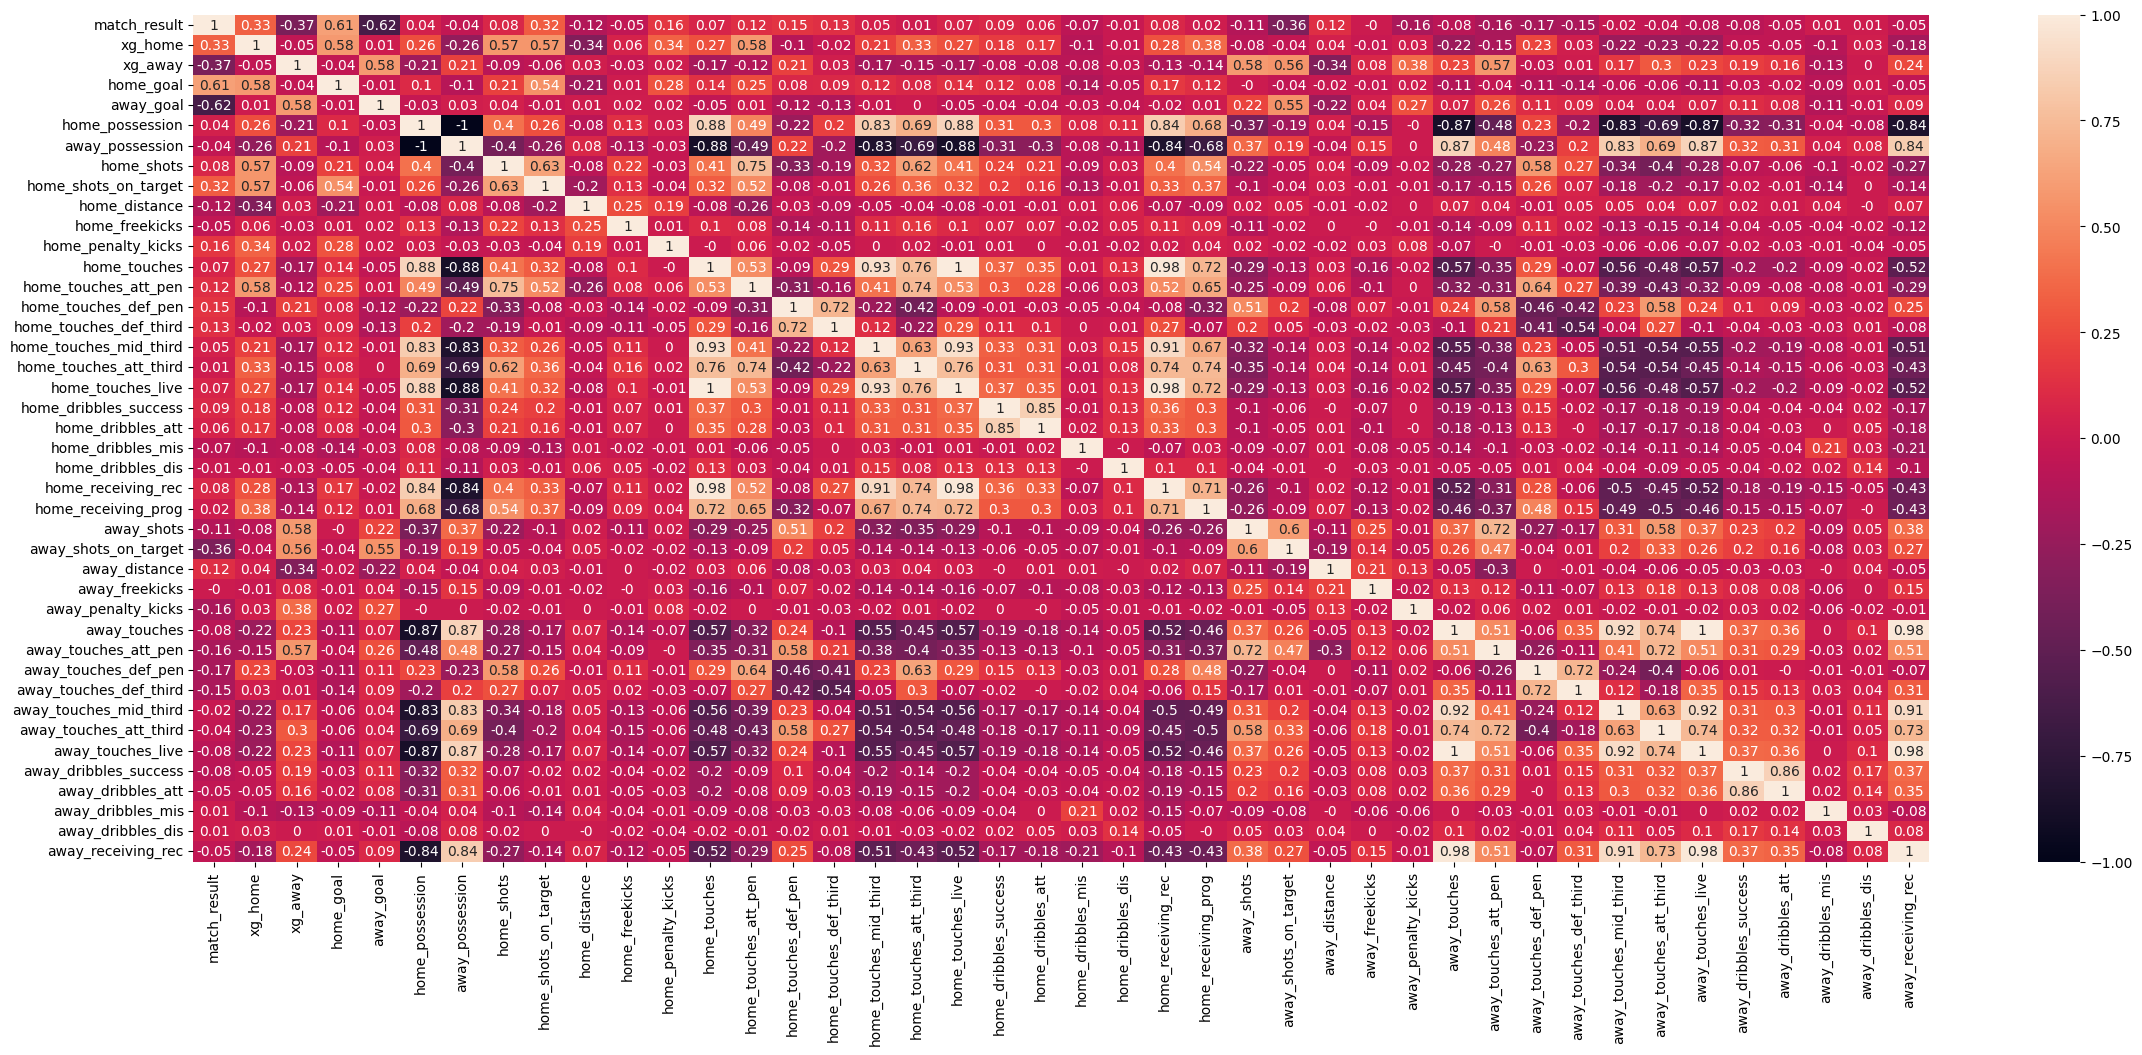

In [43]:
X1 = match_correlation_df.iloc[:,np.r_[42, 0:41]]
corrmatrix1 = X1.corr().round(2)
plt.figure(figsize = (28,11))
sns.heatmap(corrmatrix1, annot = True)
plt.savefig('numerical_correlation.png')
plt.show()


# Check for collinearity amongst numerical columns

In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [45]:
x_match_corr_df = X1.drop('match_result', 1)
y_match_corr_df= X1['match_result']

In [46]:
def cal_vif(x):
    thresh = 5
    output = pd.DataFrame()
    k=x.shape[1]
    vif = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    for i in range(1,k):
        print('Iteration no ', i)
        print(vif)
        a=np.argmax(vif)
        print('Max vif is for variable no: ', a)
        if(vif[a]<=thresh):
            break
        if(i==1):
            output = x.drop(x.columns[a], axis=1)
            vif = [variance_inflation_factor(output.values, j) for j in range (output.shape[1])]
        elif(i>1):
            output = output.drop(output.columns[a], axis=1)
            vif = [variance_inflation_factor(output.values, j) for j in range (output.shape[1])]
    return(output)

In [47]:
selected_match_corr_df = cal_vif(x_match_corr_df)
selected_match_corr_df.head()

Iteration no  1
[17.055806981976115, 13.95100922140595, 5.586880989461542, 4.550978040136464, 455.61315214284963, 418.30528156936055, 33.07742286958325, 10.541042895212712, 61.564647941761166, 1.830893065185068, 5.550479193035916, 9600712.845889997, 31.759151577171014, 69.78589861070323, 5051.093808344392, 12551.993922314987, 4136.498637616419, 9565358.40677396, 24.979582651040978, 35.00627457205982, 15.202108368186988, 9.53347680158712, 2132.0043493981375, 24.930362724488997, 26.208001764090152, 9.23355232686351, 45.79002848020429, 1.7653893200709119, 5.857485060129681, 13816629.81731827, 24.079152159898104, 79.15710132270861, 6275.135248451058, 12392.759787164025, 3103.556074877631, 13780687.381148875, 25.12313170470664, 34.61842531571854, 14.787233897129585, 8.424063760976408, 1864.4415975905397]
Max vif is for variable no:  29
Iteration no  2
[17.04496254796054, 12.395570929967151, 5.586704384170713, 4.497110368793685, 455.6076374107291, 417.8180499919711, 33.011574759811666, 10.53

,home_goal,away_goal,home_freekicks,home_penalty_kicks,home_dribbles_success,away_freekicks,away_penalty_kicks,away_dribbles_success
0,1,0,2,0,7,0,0,8
1,1,0,2,0,5,1,0,9
2,2,3,1,0,4,1,1,4
3,2,2,1,0,4,0,0,12
4,1,1,0,0,8,0,0,11


In [48]:
selected_match_corr_df.columns

Index(['home_goal', 'away_goal', 'home_freekicks', 'home_penalty_kicks',
       'home_dribbles_success', 'away_freekicks', 'away_penalty_kicks',
       'away_dribbles_success'],
      dtype='object')

## Remove features that are not significant

In [49]:
important_categories

['venue_name_Camp Nou',
 'away_captain_name_Antonio Raillo',
 'home_team_Real Madrid',
 'away_captain_name_Koke',
 'home_captain_name_Lionel Messi',
 'home_captain_name_Daniel Parejo',
 'venue_name_Estadio de Gran Canaria',
 'home_team_Sevilla',
 'home_team_Las Palmas',
 'away_captain_name_Gabi',
 'home_captain_name_Kike',
 'away_captain_name_Lionel Messi',
 'home_team_Cádiz',
 'home_captain_name_Diego Godín',
 'home_formation_4-3-3',
 'away_team_Barcelona',
 'away_captain_name_Víctor Laguardia',
 'away_captain_name_Sergio Ramos',
 'venue_name_Estadio de Mestalla',
 'away_team_Real Madrid',
 'home_formation_4-5-1',
 'home_captain_name_Markel Susaeta',
 'away_captain_name_Bruno González',
 'home_captain_name_Karim Benzema',
 'home_formation_4-2-3-1',
 'away_team_Rayo Vallecano',
 'away_captain_name_Sergio Busquets',
 'venue_name_Estadio Nuevo Mirandilla',
 'away_captain_name_David López',
 'home_team_Atlético Madrid',
 'home_team_Barcelona',
 'home_captain_name_Salvi',
 'home_team_Valen

In [50]:
numerical_cols = match_results.select_dtypes(include =['int64', 'float64']).columns

In [51]:
numerical_cols

Index(['xg_home', 'xg_away', 'home_goal', 'away_goal', 'home_possession',
       'away_possession', 'home_shots', 'home_shots_on_target',
       'home_distance', 'home_freekicks', 'home_penalty_kicks', 'home_touches',
       'home_touches_att_pen', 'home_touches_def_pen',
       'home_touches_def_third', 'home_touches_mid_third',
       'home_touches_att_third', 'home_touches_live', 'home_dribbles_success',
       'home_dribbles_att', 'home_dribbles_mis', 'home_dribbles_dis',
       'home_receiving_rec', 'home_receiving_prog', 'away_shots',
       'away_shots_on_target', 'away_distance', 'away_freekicks',
       'away_penalty_kicks', 'away_touches', 'away_touches_att_pen',
       'away_touches_def_pen', 'away_touches_def_third',
       'away_touches_mid_third', 'away_touches_att_third', 'away_touches_live',
       'away_dribbles_success', 'away_dribbles_att', 'away_dribbles_mis',
       'away_dribbles_dis', 'away_receiving_rec', 'away_receiving_prog',
       'month', 'day_of_month', 'd

In [52]:
numerical_cols = list(numerical_cols)


In [53]:
cols_to_keep = []
cols_to_keep.extend(important_categories)
cols_to_keep.extend(numerical_cols)
cols_to_keep.append('match_result')

In [54]:
cols_to_keep

['venue_name_Camp Nou',
 'away_captain_name_Antonio Raillo',
 'home_team_Real Madrid',
 'away_captain_name_Koke',
 'home_captain_name_Lionel Messi',
 'home_captain_name_Daniel Parejo',
 'venue_name_Estadio de Gran Canaria',
 'home_team_Sevilla',
 'home_team_Las Palmas',
 'away_captain_name_Gabi',
 'home_captain_name_Kike',
 'away_captain_name_Lionel Messi',
 'home_team_Cádiz',
 'home_captain_name_Diego Godín',
 'home_formation_4-3-3',
 'away_team_Barcelona',
 'away_captain_name_Víctor Laguardia',
 'away_captain_name_Sergio Ramos',
 'venue_name_Estadio de Mestalla',
 'away_team_Real Madrid',
 'home_formation_4-5-1',
 'home_captain_name_Markel Susaeta',
 'away_captain_name_Bruno González',
 'home_captain_name_Karim Benzema',
 'home_formation_4-2-3-1',
 'away_team_Rayo Vallecano',
 'away_captain_name_Sergio Busquets',
 'venue_name_Estadio Nuevo Mirandilla',
 'away_captain_name_David López',
 'home_team_Atlético Madrid',
 'home_team_Barcelona',
 'home_captain_name_Salvi',
 'home_team_Valen

In [55]:
match_results_select = match_results_encode[cols_to_keep]

# Create a Baseline Model

In [56]:
match_results_final = match_results_select.copy()

In [57]:
match_results_full = match_results_encode.copy() # Keeps all columns, no removing features

In [58]:
cat_cols = match_results_full.select_dtypes(include = 'uint8').columns

In [59]:
match_results_full[cat_cols] = match_results_full[cat_cols].astype('int64')

In [60]:
# for i,v in match_results_final.dtypes.iteritems():
#     print(i, v)

In [61]:
match_results_full.columns

Index(['xg_home', 'xg_away', 'home_goal', 'away_goal', 'home_possession',
       'away_possession', 'home_shots', 'home_shots_on_target',
       'home_distance', 'home_freekicks',
       ...
       'venue_name_Estadio Wanda Metropolitano',
       'venue_name_Estadio de Balaídos', 'venue_name_Estadio de Gran Canaria',
       'venue_name_Estadio de Mendizorroza', 'venue_name_Estadio de Mestalla',
       'venue_name_Estadio de la Cerámica',
       'venue_name_Estadio del Rayo Vallecano', 'venue_name_Iberostar Estadi',
       'venue_name_RCDE Stadium', 'venue_name_San Mamés'],
      dtype='object', length=546)

In [62]:
#Drop home_goal, away_goal, xg_home, and xg_away
X = match_results_full.drop(['match_result', 'home_goal', 'away_goal', 'xg_home', 'xg_away'], axis =1)
y = match_results_full['match_result']

In [63]:
#Have to map this for xgboost
y = y.map({"D" : 0, "HW": 1, "AW":2})


In [64]:
#Since out data has a datetime component, we have to keep this in mind
# Creating a train set with all data prior to the 2021-2022 season provides an 80/20 split
# X_train = X[X['_date_'] < '2021-08-01']
# X_test = X[X['_date_'] > '2021-08-01']
# y_train = y[y['_date_'] < '2021-08-01']
# y_test = y[y['_date_'] > '2021-08-01']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 68)

In [65]:
## Classifier 1 - DecisionTreeClassifier

In [66]:
# Bring in the classifier
clf = DecisionTreeClassifier(random_state = 67)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=67)

In [67]:
predictions = clf.predict(X_test)

In [68]:
accuracy_score(y_test, predictions)

0.5342105263157895

In [69]:
precision_score(y_test, predictions, average = None)

array([0.40697674, 0.58762887, 0.54      ])

In [70]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.41      0.35      0.38        99
           1       0.59      0.67      0.62       171
           2       0.54      0.49      0.51       110

    accuracy                           0.53       380
   macro avg       0.51      0.50      0.51       380
weighted avg       0.53      0.53      0.53       380



In [71]:
feature_imp = dict(zip(X_train.columns, clf.feature_importances_))



In [72]:
# sorted(feature_imp.items(), key=lambda x:x[1], reverse= True)

## Naive Bayes

In [73]:
nbc = MultinomialNB()
nbc.fit(X_train, y_train)

MultinomialNB()

In [74]:
y_pred = nbc.predict(X_test)

In [75]:
print(confusion_matrix(y_test,y_pred))


[[28 44 27]
 [46 88 37]
 [20 44 46]]


In [76]:
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           0       0.30      0.28      0.29        99
           1       0.50      0.51      0.51       171
           2       0.42      0.42      0.42       110

    accuracy                           0.43       380
   macro avg       0.41      0.41      0.41       380
weighted avg       0.42      0.43      0.42       380



In [77]:
print(accuracy_score(y_test, y_pred))

0.4263157894736842


## Random Forest

In [78]:
rfc = RandomForestClassifier(random_state = 67, n_jobs = 4)
rfc.fit(X_train, y_train)



RandomForestClassifier(n_jobs=4, random_state=67)

In [79]:
y_pred = rfc.predict(X_test)



In [80]:
print(confusion_matrix(y_test,y_pred))

[[ 17  62  20]
 [ 18 137  16]
 [ 15  44  51]]


In [81]:

print(classification_report(y_test,y_pred)) 


              precision    recall  f1-score   support

           0       0.34      0.17      0.23        99
           1       0.56      0.80      0.66       171
           2       0.59      0.46      0.52       110

    accuracy                           0.54       380
   macro avg       0.50      0.48      0.47       380
weighted avg       0.51      0.54      0.51       380



In [82]:
print(accuracy_score(y_test, y_pred))

0.5394736842105263


## SVC

In [83]:
cls_svc = SVC(random_state = 67)

In [84]:
cls_svc.fit(X_train, y_train)

SVC(random_state=67)

In [85]:
y_pred = cls_svc.predict(X_test)

In [86]:
print(confusion_matrix(y_test,y_pred))

[[  0  99   0]
 [  0 171   0]
 [  0 110   0]]


In [87]:
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        99
           1       0.45      1.00      0.62       171
           2       0.00      0.00      0.00       110

    accuracy                           0.45       380
   macro avg       0.15      0.33      0.21       380
weighted avg       0.20      0.45      0.28       380



In [88]:
print(accuracy_score(y_test, y_pred))

0.45


# XgBoost

In [89]:
cls_xg = xgb.XGBClassifier(random_state = 67, 
                           n_jobs=4)

In [90]:
cls_xg.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=4, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [91]:
y_pred = cls_xg.predict(X_test)

In [92]:
confusion_matrix(y_test, y_pred)

array([[ 29,  49,  21],
       [ 20, 127,  24],
       [ 25,  16,  69]], dtype=int64)

In [93]:
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           0       0.39      0.29      0.34        99
           1       0.66      0.74      0.70       171
           2       0.61      0.63      0.62       110

    accuracy                           0.59       380
   macro avg       0.55      0.55      0.55       380
weighted avg       0.57      0.59      0.58       380



In [94]:
print(accuracy_score(y_test, y_pred))

0.5921052631578947


# Tune the models
Here we will move forward with Random Forest, XgBoost, and DecisionTreeClassifier 

## Show Parameters For each model for reference

In [95]:
rfc.get_params() # Random Forest

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 4,
 'oob_score': False,
 'random_state': 67,
 'verbose': 0,
 'warm_start': False}

In [96]:
clf.get_params() #DecisionTreeClassifier

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 67,
 'splitter': 'best'}

In [97]:
cls_xg.get_params() #XgBoost

{'objective': 'multi:softprob',
 'use_label_encoder': None,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 67,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [98]:
params_dt = {
    "splitter" : ["best", "random"],
    "criterion" : ["gini", "entropy"],
    "max_depth" : [2,3,4,5],
   #  'min_samples_leaf' : [1,2,3,4],
   #  "min_weight_fraction_leaf" : [0.0, 0.01],
   #  'min_samples_split': [2,3,4,5],
    "max_features" : [None, 'sqrt'],
   #  "class_weight": [None, 'balanced'],
   #  "max_leaf_nodes" : [2,3,4],
   # "min_impurity_decrease" : [0.0, 0.01]
}

params_rf = {
    "n_estimators": [100, 200, 300, 400, 500, 600,700, 800],
    "criterion" : ["gini", "entropy"],
    # "class_weight": ['balanced', 'balanced_subsample'],
    "max_depth" : [2,3,4,5,6,7,8,9,10],
    "max_features" : [None, 'sqrt'],
    # "max_leaf_nodes" : [2,3,5],
    # 'min_samples_leaf' : [1,2,3],
    # 'min_samples_split': [2,3,4],
    #  "min_weight_fraction_leaf" : [0.0, 0.01],
    # "min_impurity_decrease" : [0.0, 0.01]
}

params_xgb = {
     "n_estimators": [100, 250, 300, 500, 600, 750, 1000, 1200],
    "learning_rate" : [0.01, 0.025, 0.05, 0.075, 0.1],
    # "booster" : ["gbtree" , "gblinear" , "dart"],
    "max_depth" : [5,6,7,8,9,10,11],
    # "min_child_weight" : [1,2],
    # "max_leaves" : [2, 4, 6, 8],
    # "gamma" : [0, 1],
    #"num_parallel_tree" : [1,2],
    #"tree_method" : ['approx', 'exact', 'hist'],
}

## DecisionTreeClassifier Tuned

In [99]:
# clf_dt_tuned = GridSearchCV(
#     estimator = clf,
#     param_grid=params_dt,
#     cv = 5, 
#     n_jobs = 4,
#     verbose = 6
# )

clf_dt_tuned = HalvingGridSearchCV(
    estimator = clf,
    param_grid=params_dt,
    cv = 5,
    n_jobs = 4,
    verbose = 6
)
    

In [100]:
start = time.time()
clf_dt_tuned.fit(X_train, y_train)


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 56
max_resources_: 1520
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 32
n_resources: 56
Fitting 5 folds for each of 32 candidates, totalling 160 fits
----------
iter: 1
n_candidates: 11
n_resources: 168
Fitting 5 folds for each of 11 candidates, totalling 55 fits
----------
iter: 2
n_candidates: 4
n_resources: 504
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 3
n_candidates: 2
n_resources: 1512
Fitting 5 folds for each of 2 candidates, totalling 10 fits


HalvingGridSearchCV(estimator=DecisionTreeClassifier(random_state=67), n_jobs=4,
                    param_grid={'criterion': ['gini', 'entropy'],
                                'max_depth': [2, 3, 4, 5],
                                'max_features': [None, 'sqrt'],
                                'splitter': ['best', 'random']},
                    verbose=6)

In [101]:
end = time.time()
print(f"Time taken to run: {end - start} seconds")

Time taken to run: 7.980595111846924 seconds


In [102]:
clf_dt_tuned.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': None,
 'splitter': 'best'}

In [103]:
y_pred = clf_dt_tuned.predict(X_test)

In [104]:
confusion_matrix(y_test, y_pred)

array([[ 35,  35,  29],
       [ 29, 124,  18],
       [ 22,  34,  54]], dtype=int64)

In [105]:
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           0       0.41      0.35      0.38        99
           1       0.64      0.73      0.68       171
           2       0.53      0.49      0.51       110

    accuracy                           0.56       380
   macro avg       0.53      0.52      0.52       380
weighted avg       0.55      0.56      0.55       380



In [106]:
print(accuracy_score(y_test, y_pred))

0.5605263157894737


## Random Forest Tuned

In [107]:
# clf_rf_tuned = GridSearchCV(
#     estimator = rfc,
#     param_grid=params_rf,
#     cv = 5, 
#     n_jobs = 3,
#     verbose = 6
# )

clf_rf_tuned = HalvingGridSearchCV(
    estimator = rfc,
    param_grid=params_rf,
    cv = 5, 
    n_jobs = 4,
    verbose = 6
)



In [108]:
start = time.time()
clf_rf_tuned.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 6
n_possible_iterations: 4
min_resources_: 30
max_resources_: 1520
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 288
n_resources: 30
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
----------
iter: 1
n_candidates: 96
n_resources: 90
Fitting 5 folds for each of 96 candidates, totalling 480 fits
----------
iter: 2
n_candidates: 32
n_resources: 270
Fitting 5 folds for each of 32 candidates, totalling 160 fits
----------
iter: 3
n_candidates: 11
n_resources: 810
Fitting 5 folds for each of 11 candidates, totalling 55 fits


HalvingGridSearchCV(estimator=RandomForestClassifier(n_jobs=4, random_state=67),
                    n_jobs=4,
                    param_grid={'criterion': ['gini', 'entropy'],
                                'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                                'max_features': [None, 'sqrt'],
                                'n_estimators': [100, 200, 300, 400, 500, 600,
                                                 700, 800]},
                    verbose=6)

In [109]:
end = time.time()
print(f"Time taken to run: {end - start} seconds")

Time taken to run: 1325.4461696147919 seconds


In [110]:
clf_rf_tuned.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'n_estimators': 100}

In [111]:
y_pred = clf_rf_tuned.predict(X_test)

In [112]:
confusion_matrix(y_test, y_pred)

array([[ 22,  45,  32],
       [ 17, 133,  21],
       [ 14,  30,  66]], dtype=int64)

In [113]:
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           0       0.42      0.22      0.29        99
           1       0.64      0.78      0.70       171
           2       0.55      0.60      0.58       110

    accuracy                           0.58       380
   macro avg       0.54      0.53      0.52       380
weighted avg       0.56      0.58      0.56       380



In [114]:
print(accuracy_score(y_test, y_pred))

0.5815789473684211


## XGBoost Tuned

In [115]:
# clf_xgb_tuned = GridSearchCV(
#     estimator = cls_xg,
#     param_grid=params_xgb,
#     cv = 5,
#     n_jobs = 4,
#     verbose = 6
# )

clf_xgb_tuned = HalvingGridSearchCV(
    estimator = cls_xg,
    param_grid=params_xgb,
    cv = 5,
    n_jobs = 4,
    verbose = 6
)

In [116]:
start = time.time()
clf_xgb_tuned.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 6
n_possible_iterations: 4
min_resources_: 30
max_resources_: 1520
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 280
n_resources: 30
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
----------
iter: 1
n_candidates: 94
n_resources: 90
Fitting 5 folds for each of 94 candidates, totalling 470 fits
----------
iter: 2
n_candidates: 32
n_resources: 270
Fitting 5 folds for each of 32 candidates, totalling 160 fits
----------
iter: 3
n_candidates: 11
n_resources: 810
Fitting 5 folds for each of 11 candidates, totalling 55 fits


HalvingGridSearchCV(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.3000000...
                                            max_delta_step=0, max_depth=6,
                                            max_leaves=0, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=4,
                                            num_parallel_tree=1,
                                            objective='multi:softprob',
                                            predictor='auto', ...),
                    n_jobs=4,
                    param_grid={'learning_rate': [0.01, 0.025, 0.05, 0.075,
                                                  0.1],
                                'max_depth': [5, 6, 7, 8, 9, 10, 11],
                                'n_estimators': [100, 250, 300, 500, 600, 750,
                                                 1000, 1200]},
                    verbose=6)

In [117]:
end = time.time()
print(f"Time taken to run: {end - start} seconds")

Time taken to run: 6260.276185512543 seconds


In [118]:
clf_xgb_tuned.best_params_

{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1200}

In [119]:
y_pred = clf_xgb_tuned.predict(X_test)

In [120]:
confusion_matrix(y_test, y_pred)

array([[ 37,  39,  23],
       [ 24, 126,  21],
       [ 22,  20,  68]], dtype=int64)

In [121]:
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           0       0.45      0.37      0.41        99
           1       0.68      0.74      0.71       171
           2       0.61      0.62      0.61       110

    accuracy                           0.61       380
   macro avg       0.58      0.58      0.58       380
weighted avg       0.60      0.61      0.60       380



In [122]:
print(accuracy_score(y_test, y_pred))

0.6078947368421053
